# Image - 분류 (Classification) 통합 템플릿
## Google Colab 실행용

- NUM_CLASSES = 2 → 이진분류 / NUM_CLASSES >= 3 → 다중분류
- softmax + categorical_crossentropy로 통일 → 코드 변경 없이 자동 대응
- 모델: MobileNetV2 Transfer Learning + Fine-tuning

**실행 전**: 런타임 > 런타임 유형 변경 > GPU(T4) 선택

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print(f"TensorFlow: {tf.__version__}")
print(f"GPU: {tf.config.list_physical_devices('GPU')}")

TensorFlow: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1. 하이퍼파라미터

In [2]:
INPUT_SHAPE = (224, 224, 3)
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 1e-3
FINE_TUNE_EPOCHS = 20
FINE_TUNE_LR = 1e-5

## 2. 데이터 로드

In [5]:
import pathlib

# ==============================================
# [데이터셋 선택] 아래 중 하나만 주석 해제
# ==============================================

# --- (A) Flower Photos (5클래스 다중분류) ---
# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
# data_dir = pathlib.Path(data_dir)
# if (data_dir / 'flower_photos').exists():
#     data_dir = data_dir / 'flower_photos'
# USE_SPLIT = True

# --- (B) Cats and Dogs (2클래스 이진분류) ---
# Hugging Face에서 다운로드 후 폴더 구조로 저장
import subprocess
subprocess.run(['pip', 'install', '-q', 'datasets'])
from datasets import load_dataset

label_names = ['cat', 'dog']
data_dir = pathlib.Path('/content/cats_vs_dogs')

if not data_dir.exists():
    print("데이터셋 다운로드 중 (Hugging Face)...")
    hf_ds = load_dataset('microsoft/cats_vs_dogs', split='train')
    for name in label_names:
        (data_dir / name).mkdir(parents=True, exist_ok=True)
    print(f"이미지 저장 중 ({len(hf_ds)}장)...")
    for i, sample in enumerate(hf_ds):
        label_name = label_names[sample['labels']]
        sample['image'].convert('RGB').save(
            str(data_dir / label_name / f'{i:05d}.jpg'), 'JPEG'
        )
        if (i + 1) % 5000 == 0:
            print(f"  {i + 1}장 완료...")
    print(f"총 {i + 1}장 저장 완료")
else:
    print(f"기존 데이터 사용: {data_dir}")

USE_SPLIT = True

print(f"데이터 경로: {data_dir}")
print(f"하위 폴더: {sorted([d.name for d in data_dir.iterdir() if d.is_dir()])}")

if USE_SPLIT:
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir, label_mode='categorical',
        validation_split=0.2, subset='training',
        image_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
        seed=RANDOM_SEED, shuffle=True,
    )
    val_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir, label_mode='categorical',
        validation_split=0.2, subset='validation',
        image_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
        seed=RANDOM_SEED, shuffle=True,
    )
else:
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir / 'train', label_mode='categorical',
        image_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
        seed=RANDOM_SEED, shuffle=True,
    )
    val_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir / 'validation', label_mode='categorical',
        image_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
        seed=RANDOM_SEED, shuffle=True,
    )

class_names = train_ds.class_names
NUM_CLASSES = len(class_names)

val_file_paths = list(val_ds.file_paths)
val_filenames = [os.path.basename(fp) for fp in val_file_paths]
val_parent_dirs = [os.path.basename(os.path.dirname(fp)) for fp in val_file_paths]

print(f"클래스({NUM_CLASSES}): {class_names}")
print(f"{'이진분류' if NUM_CLASSES == 2 else '다중분류'}")
print(f"Train 배치: {len(train_ds)}, Val 배치: {len(val_ds)}")

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

# 예측용 정렬 데이터셋 (file_paths 순서 보장)
def _load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    return img

val_pred_ds = tf.data.Dataset.from_tensor_slices(val_file_paths)
val_pred_ds = val_pred_ds.map(_load_image, num_parallel_calls=AUTOTUNE)
val_pred_ds = val_pred_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

데이터셋 다운로드 중 (Hugging Face)...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/330M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/391M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/23410 [00:00<?, ? examples/s]

이미지 저장 중 (23410장)...
  5000장 완료...
  10000장 완료...
  15000장 완료...
  20000장 완료...
총 23410장 저장 완료
데이터 경로: /content/cats_vs_dogs
하위 폴더: ['cat', 'dog']
Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.
클래스(2): ['cat', 'dog']
이진분류
Train 배치: 586, Val 배치: 147


## 2-1. EDA

[클래스별 이미지 수]
  cat: 11741장
  dog: 11669장


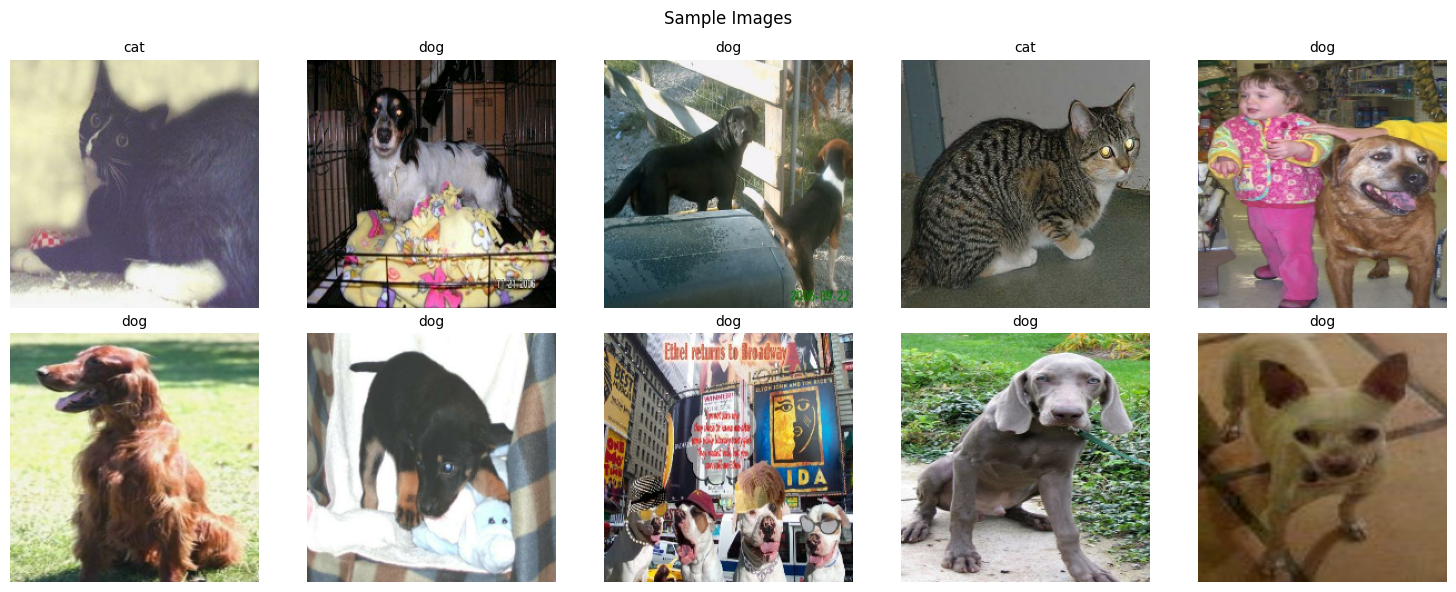

In [6]:
print("[클래스별 이미지 수]")
if USE_SPLIT:
    for cls in class_names:
        cls_dir = data_dir / cls
        if cls_dir.exists():
            print(f"  {cls}: {len(list(cls_dir.glob('*')))}장")
else:
    for split_name in ['train', 'validation']:
        print(f"  [{split_name}]")
        for cls in class_names:
            cls_dir = data_dir / split_name / cls
            if cls_dir.exists():
                print(f"    {cls}: {len(list(cls_dir.glob('*')))}장")

plt.figure(figsize=(15, 6))
for images, labels in train_ds.take(1):
    for i in range(min(10, len(images))):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_idx = np.argmax(labels[i])
        plt.title(class_names[label_idx], fontsize=10)
        plt.axis("off")
plt.suptitle('Sample Images')
plt.tight_layout()
plt.show()

## 3. 데이터 증강 + 4. 모델 구축

In [7]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

base_model = tf.keras.applications.MobileNetV2(
    input_shape=INPUT_SHAPE, weights='imagenet', include_top=False
)
base_model.trainable = False

inputs = tf.keras.Input(shape=INPUT_SHAPE)
x = data_augmentation(inputs)
x = tf.keras.layers.Rescaling(1./127.5, offset=-1)(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,434 (9.87 MB)

 Trainable params: 328,450 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 5. Phase 1 - Feature Extraction

In [8]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7),
]

print("Phase 1: Feature Extraction (base model frozen)")
history = model.fit(
    train_ds, validation_data=val_ds,
    epochs=EPOCHS, callbacks=callbacks, verbose=1
)

Phase 1: Feature Extraction (base model frozen)
Epoch 1/30
586/586 ━━━━━━━━━━━━━━━━━━━━ 56s 79ms/step - accuracy: 0.9316 - loss: 0.1768 - val_accuracy: 0.9895 - val_loss: 0.0374 - learning_rate: 0.0010
Epoch 2/30
586/586 ━━━━━━━━━━━━━━━━━━━━ 44s 75ms/step - accuracy: 0.9554 - loss: 0.1101 - val_accuracy: 0.9883 - val_loss: 0.0318 - learning_rate: 0.0010
Epoch 3/30
586/586 ━━━━━━━━━━━━━━━━━━━━ 84s 78ms/step - accuracy: 0.9629 - loss: 0.0954 - val_accuracy: 0.9904 - val_loss: 0.0268 - learning_rate: 0.0010
Epoch 4/30
586/586 ━━━━━━━━━━━━━━━━━━━━ 82s 78ms/step - accuracy: 0.9612 - loss: 0.0941 - val_accuracy: 0.9904 - val_loss: 0.0243 - learning_rate: 0.0010
Epoch 5/30
586/586 ━━━━━━━━━━━━━━━━━━━━ 48s 82ms/step - accuracy: 0.9602 - loss: 0.0933 - val_accuracy: 0.9917 - val_loss: 0.0243 - learning_rate: 0.0010
Epoch 6/30
586/586 ━━━━━━━━━━━━━━━━━━━━ 80s 78ms/step - accuracy: 0.9650 - loss: 0.0915 - val_accuracy: 0.9895 - val_loss: 0.0289 - learning_rate: 0.0010
Epoch 7/30
586/586 ━━━━━━━━━

## 6. Phase 2 - Fine-Tuning

In [11]:
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 30
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"Fine-tuning: last {len(base_model.layers) - fine_tune_at} layers")

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=FINE_TUNE_LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_ft = model.fit(
    train_ds, validation_data=val_ds,
    epochs=FINE_TUNE_EPOCHS, callbacks=callbacks, verbose=1
)

Fine-tuning: last 30 layers
Epoch 1/3
586/586 ━━━━━━━━━━━━━━━━━━━━ 66s 97ms/step - accuracy: 0.9663 - loss: 0.0809 - val_accuracy: 0.9934 - val_loss: 0.0225 - learning_rate: 1.0000e-05
Epoch 2/3
586/586 ━━━━━━━━━━━━━━━━━━━━ 59s 100ms/step - accuracy: 0.9713 - loss: 0.0739 - val_accuracy: 0.9925 - val_loss: 0.0224 - learning_rate: 1.0000e-05
Epoch 3/3
586/586 ━━━━━━━━━━━━━━━━━━━━ 57s 97ms/step - accuracy: 0.9724 - loss: 0.0709 - val_accuracy: 0.9917 - val_loss: 0.0230 - learning_rate: 1.0000e-05


## 7. 학습 곡선

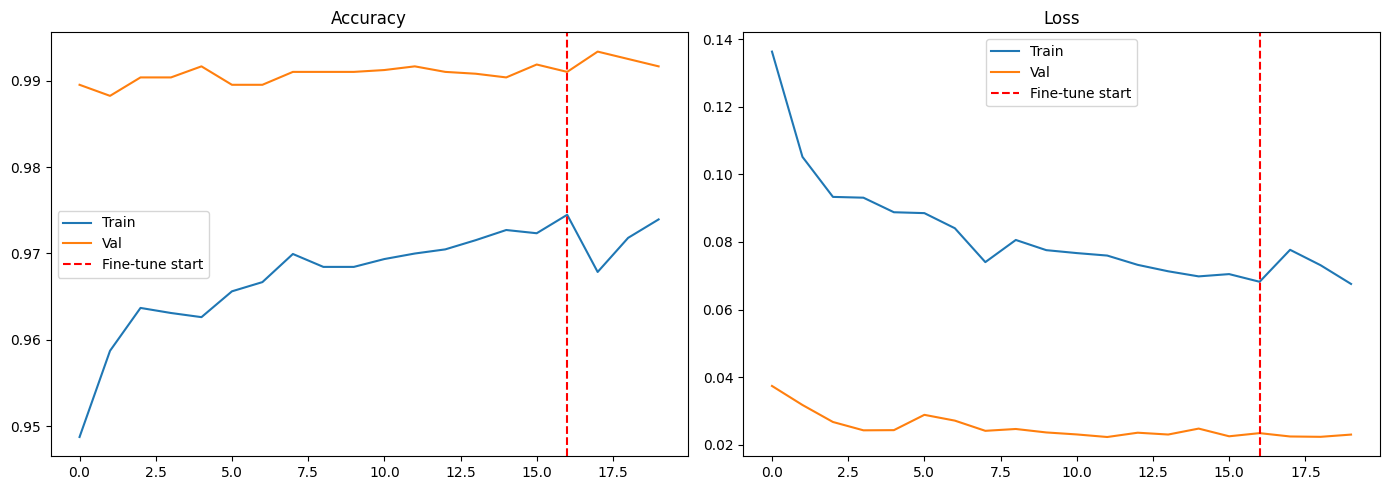

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

all_acc = history.history['accuracy'] + history_ft.history['accuracy']
all_val_acc = history.history['val_accuracy'] + history_ft.history['val_accuracy']
all_loss = history.history['loss'] + history_ft.history['loss']
all_val_loss = history.history['val_loss'] + history_ft.history['val_loss']

ax1.plot(all_acc, label='Train'); ax1.plot(all_val_acc, label='Val')
ax1.axvline(x=len(history.history['accuracy'])-1, color='r', linestyle='--', label='Fine-tune start')
ax1.legend(); ax1.set_title('Accuracy')

ax2.plot(all_loss, label='Train'); ax2.plot(all_val_loss, label='Val')
ax2.axvline(x=len(history.history['loss'])-1, color='r', linestyle='--', label='Fine-tune start')
ax2.legend(); ax2.set_title('Loss')

plt.tight_layout()
plt.show()

## 8. 최종 평가

[최종 모델 성능]
Accuracy:   0.9934
F1 (macro): 0.9934

[분류 보고서]
              precision    recall  f1-score   support

         cat       0.99      0.99      0.99      2310
         dog       0.99      0.99      0.99      2372

    accuracy                           0.99      4682
   macro avg       0.99      0.99      0.99      4682
weighted avg       0.99      0.99      0.99      4682



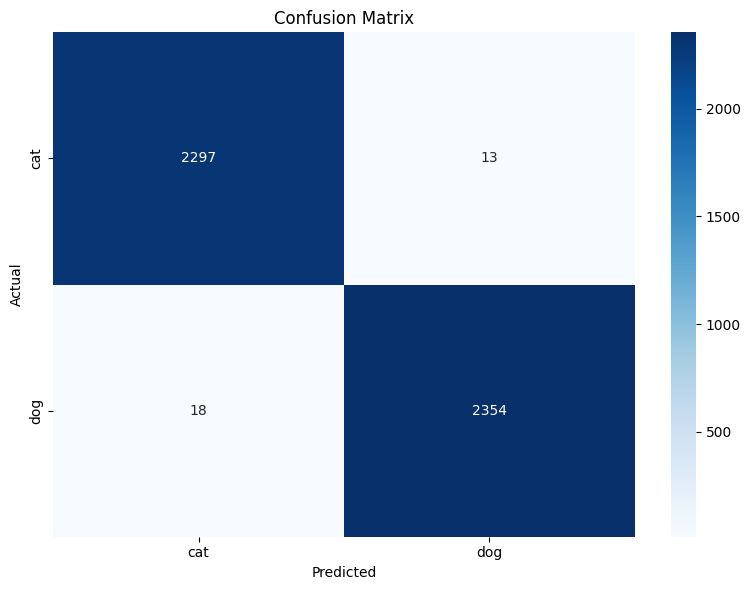

In [13]:
if os.path.exists('best_model.keras'):
    model = tf.keras.models.load_model('best_model.keras')

# val_pred_ds로 순서 보장된 예측 수행
all_preds = []
all_confs = []
for images in val_pred_ds:
    preds = model.predict(images, verbose=0)
    all_preds.extend(np.argmax(preds, axis=1))
    all_confs.extend([preds[i][np.argmax(preds[i])] for i in range(len(preds))])

# 실제 레이블은 디렉토리명(=클래스명)에서 추출
all_labels = [class_names.index(d) for d in val_parent_dirs]

acc_final = accuracy_score(all_labels, all_preds)
f1_final = f1_score(all_labels, all_preds, average='macro')

print(f"[최종 모델 성능]")
print(f"Accuracy:   {acc_final:.4f}")
print(f"F1 (macro): {f1_final:.4f}")
print(f"\n[분류 보고서]")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

## 성능 평가 기준

| 등급 | Accuracy | F1 (macro) |
|------|----------|------------|
| 매우 우수 | >= 0.95 | >= 0.90 |
| 우수 | 0.90~0.95 | 0.80~0.90 |
| 양호 | 0.85~0.90 | 0.70~0.80 |
| 보통 | 0.80~0.85 | 0.60~0.70 |
| 미흡 | < 0.80 | < 0.60 |

In [14]:
acc_grades = [(0.95, '매우 우수'), (0.90, '우수'), (0.85, '양호'), (0.80, '보통')]
acc_grade = '미흡'
for threshold, grade in acc_grades:
    if acc_final >= threshold:
        acc_grade = grade
        break

f1_grades = [(0.90, '매우 우수'), (0.80, '우수'), (0.70, '양호'), (0.60, '보통')]
f1_grade = '미흡'
for threshold, grade in f1_grades:
    if f1_final >= threshold:
        f1_grade = grade
        break

print(f"[성능 평가]")
print(f"Accuracy = {acc_final:.4f} -> {acc_grade}")
print(f"F1 Score = {f1_final:.4f} -> {f1_grade}")

[성능 평가]
Accuracy = 0.9934 -> 매우 우수
F1 Score = 0.9934 -> 매우 우수


## 예측 시각화

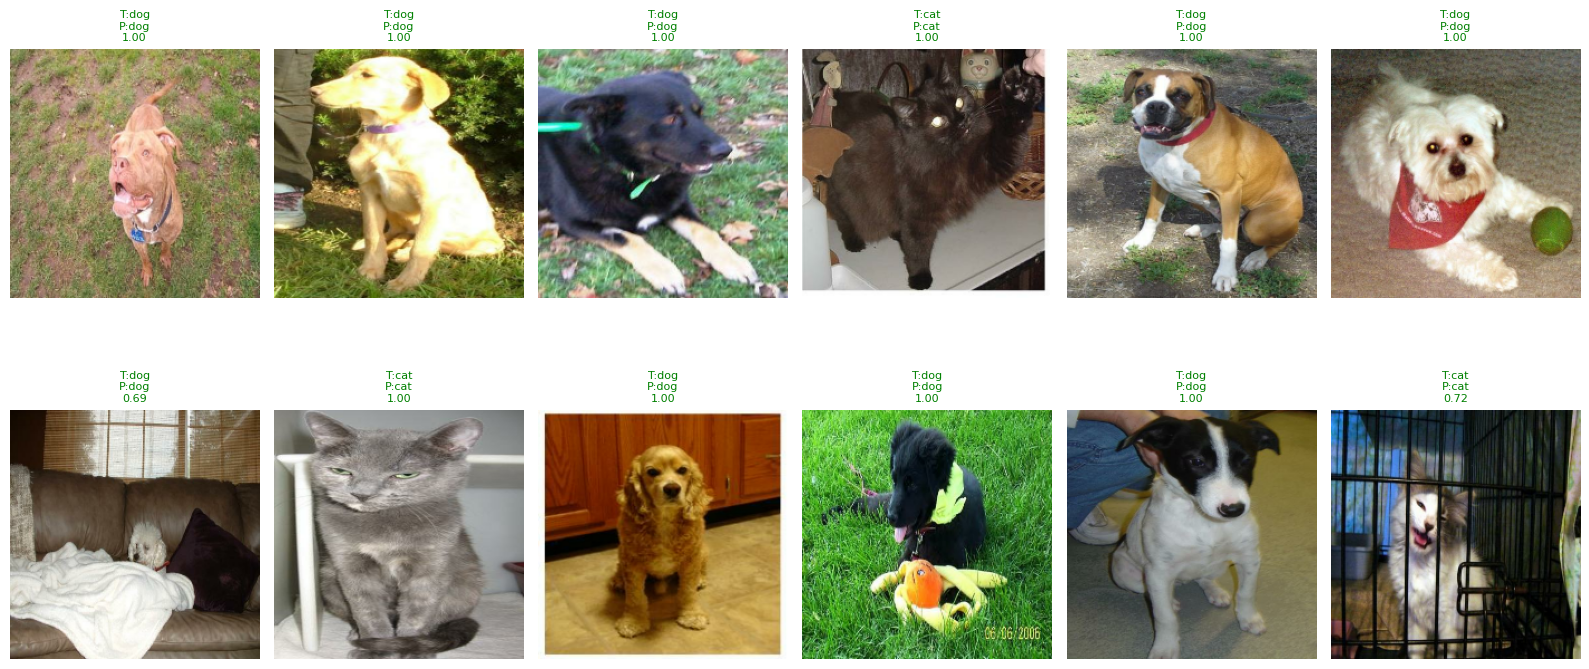

In [15]:
plt.figure(figsize=(16, 8))
for images, labels in val_ds.take(1):
    preds = model.predict(images, verbose=0)
    for i in range(min(12, len(images))):
        ax = plt.subplot(2, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_idx = np.argmax(labels[i])
        pred_idx = np.argmax(preds[i])
        conf = preds[i][pred_idx]
        color = 'green' if true_idx == pred_idx else 'red'
        plt.title(f'T:{class_names[true_idx]}\nP:{class_names[pred_idx]}\n{conf:.2f}',
                  color=color, fontsize=8)
        plt.axis("off")
plt.tight_layout()
plt.show()

## 9. 결과 CSV 파일 생성

In [16]:
# --- 디렉토리명 vs 예측명 일치 비율 ---
dir_pred_match = sum(d == p for d, p in zip(val_parent_dirs, [class_names[i] for i in all_preds]))
dir_pred_total = len(val_parent_dirs)
print(f"\n[디렉토리명 vs 예측명 일치 비율]")
print(f"  일치: {dir_pred_match} / {dir_pred_total} ({dir_pred_match/dir_pred_total:.4f})")
print(f"  불일치: {dir_pred_total - dir_pred_match}건")

result_df = pd.DataFrame({
    'directory': val_parent_dirs,
    'filename': val_filenames,
    'actual': all_labels,
    'predicted': all_preds,
    'actual_name': [class_names[i] for i in all_labels],
    'predicted_name': [class_names[i] for i in all_preds],
    'confidence': all_confs,
    'correct': [1 if a == p else 0 for a, p in zip(all_labels, all_preds)],
})

result_df = result_df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
result_df.to_csv('image_classification_result.csv', index=False)
print(f"[저장] image_classification_result.csv ({len(result_df)}건)")
print(result_df.head(10))

summary_df = pd.DataFrame([{
    'model': 'MobileNetV2 (Fine-tuned)',
    'accuracy': acc_final,
    'f1_macro': f1_final,
    'accuracy_grade': acc_grade,
    'f1_grade': f1_grade,
    'num_classes': NUM_CLASSES,
    'class_names': str(class_names),
}])
summary_df.to_csv('image_classification_summary.csv', index=False)
print(f"\n[저장] image_classification_summary.csv")
print(summary_df)


[디렉토리명 vs 예측명 일치 비율]
  일치: 4651 / 4682 (0.9934)
  불일치: 31건
[저장] image_classification_result.csv (4682건)
  directory   filename  actual  predicted actual_name predicted_name  \
0       dog  22614.jpg       1          1         dog            dog   
1       cat  06540.jpg       0          0         cat            cat   
2       cat  02520.jpg       0          0         cat            cat   
3       dog  15563.jpg       1          1         dog            dog   
4       cat  00698.jpg       0          0         cat            cat   
5       dog  18944.jpg       1          1         dog            dog   
6       dog  11999.jpg       1          1         dog            dog   
7       cat  11111.jpg       0          0         cat            cat   
8       dog  14025.jpg       1          1         dog            dog   
9       dog  13686.jpg       1          1         dog            dog   

   confidence  correct  
0    0.999991        1  
1    1.000000        1  
2    1.000000        1  
3 

## 10. 모델 저장

In [17]:
model.save('image_classification_model.keras')
print("모델 저장 완료: image_classification_model.keras")

모델 저장 완료: image_classification_model.keras
